In [1]:
!pip install yfinance
!pip install numpy pandas scikit-learn matplotlib tensorflow

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/db/fc/10b7d339ccf6725e13408d76fb1e944f512590a949af426503c38d4af712/yfinance-0.2.41-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/6a/71/3656c00606e75e81f11721e6a1c973c3e03da8c7d8b665d20f78245384c6/frozendict-2.4.4-py311-none-any.whl.metadata
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     -- ------------------------------------- 0.2/3.0 MB 5.3 MB/s eta 0:00:01
     ----------------- ---------------------- 1.3/3.0 MB 16.1 MB/s eta 0:00:01
     ------------------------------- -------- 2.3/3.0 MB 18.6 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [4]:
def preprocess_data(stock_data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
    
    train_data_len = int(np.ceil(len(scaled_data) * 0.8))
    train_data = scaled_data[0:train_data_len, :]
    
    x_train = []
    y_train = []
    
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    test_data = scaled_data[train_data_len - 60:, :]
    x_test = []
    y_test = stock_data['Close'][train_data_len:].values
    
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, scaler

In [5]:
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(60, 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [6]:
def train_model(model, x_train, y_train, epochs=1, batch_size=1):
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

In [7]:
def evaluate_model(model, x_test, y_test, scaler):
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
    print(f'Root Mean Squared Error: {rmse}')
    
    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD')
    plt.plot(y_test, label='Actual Price')
    plt.plot(predictions, label='Predicted Price')
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    plt.show()

[*********************100%%**********************]  1 of 1 completed
C:\Users\Melsa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2357/2357 ━━━━━━━━━━━━━━━━━━━━ 91s 36ms/step - loss: 2.8071e-04
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Root Mean Squared Error: 6.115513959467806


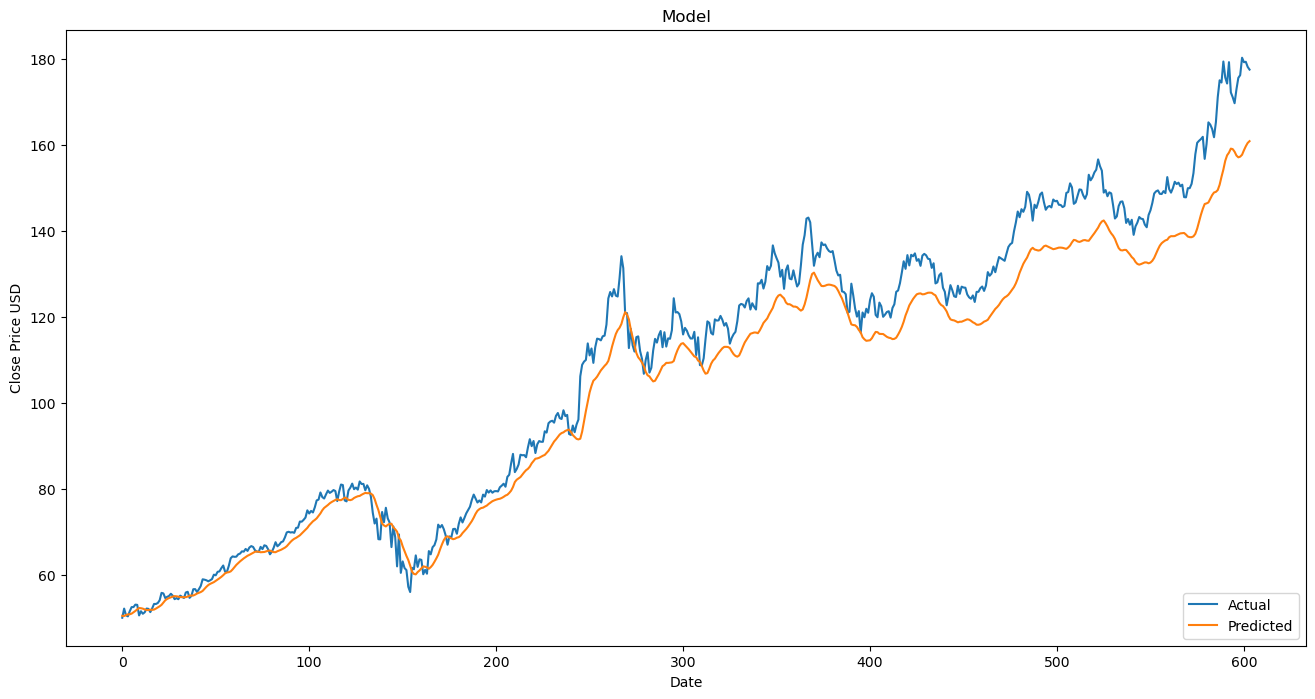

In [9]:
#Main Function
ticker = 'AAPL'  # Example: Apple Inc.
start_date = '2010-01-01'
end_date = '2022-01-01'
    
stock_data = get_stock_data(ticker, start_date, end_date)
x_train, y_train, x_test, y_test, scaler = preprocess_data(stock_data)
model = build_model()
train_model(model, x_train, y_train, epochs=1, batch_size=1)
    
evaluate_model(model, x_test, y_test, scaler)